In [28]:
import MySQLdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook,tqdm
import pickle
pd.set_option('max_row',1000)
pd.set_option('max_column',1000)

In [2]:
# conn = MySQLdb.connect(host="127.0.0.1",
#                                  user="root",
#                                  passwd="root123",
#                                  db="football",
#                                  charset = 'utf8'
#                         )

In [3]:
# leagues = pd.read_sql_query('select * from league',conn)
# match_stats = pd.read_sql_query('select * from match_stats', conn)
# matches = pd.read_sql_query('select * from matches', conn)
# teams = pd.read_sql_query('select * from team', conn)
# kickoff_handicaps = pd.read_sql_query('select * from kickoff_handicap',conn)

In [4]:
# leagues.shape, match_stats.shape, matches.shape, teams.shape, kickoff_handicaps.shape

### Data summary

1. League 包含的是比赛的性质，杯赛还是联赛，大赛的名称，简称
2. 有用的信息包括id， abrreviation， leagure_name， league_type

In [5]:
# leagues.head()

1. Matches 包含的是每场比赛的信息
2. 字段含义： 所有的字段都是两队的和， 不特指单一球队
    - id - 比赛的唯一ID   
    - first_half_time_corners: 上半场的角球数
    - first_half_time_goals: 上半场的进球数
    - first_half_time_score: 上半场的比分 - 需要清洗
    - full_time_corners: 全场角球数
    - full_time_goals: 全场的进球数
    - full_time_score: 全场的比分 - 需要清洗
    - league_id： 大概是和league表的id关联的
    - match_start_time: 比赛的开始时间
    - second_half_time_goals: 下半场的进球数
    - home_team_id: 主队id
    - away_team_id:客队id
    - league_type: 联赛类型
    - women:是不是女子球赛
    
     
    

In [6]:
# matches.head()

Match_stats: 一场比赛中，主队或客队的比赛信息，
    - id: groupby 比赛,队伍
    - home_team:  1 - 主队， 0 - 客队
    - attacks: 进攻次数
    - dangerous_attacks: 危险进攻次数
    - first_half_time_corner: 上半场角球数
    - first_half_time_goals: 上半场进球数
    - first_half_time_goals_against: 上半场被进球数
    - full_time_corners: 全场角球数量
    - full_time_goals： 全场进球数
    - full_time_goals_against： 全场被进球数
    - league_id: 联赛id和league表关联
    - match_id: 和match表关联
    - match_result：比赛结果，胜负平 - 分类的预测目标
    - off_targets: 射偏数
    - on_targets: 射正数
    - red_cards：红牌数
    - second_half_time_goals: 下半场进球数
    - second_half_time_goals_against： 下半场被进球数
    - shots: 总射门数
    - team_id: 队伍id，关联team表
    - yellow_cards: 黄牌数量

In [7]:
# match_stats.head()

清洗match_stats表

In [8]:
# to_drop_stats = ['create_time','update_time', 'first_half_time_corners','full_time_corners']
# match_stats = match_stats.drop(to_drop_stats, axis = 1)

清洗matches表

In [9]:
# matches.head()

In [10]:
# to_drop_matches = ['create_time','update_time', 'first_half_time_corners','full_time_corners']
# matches = matches.drop(to_drop_matches, axis = 1)

清洗league表

In [11]:
# to_drop_leagues = ['create_time','update_time','abbreviation','type','top']
# leagues = leagues.drop(to_drop_leagues, axis = 1)

清洗team表

In [12]:
# to_drop_teams = ['create_time','update_time']
# teams = teams.drop(to_drop_teams, axis = 1)

清洗kickoff_handicaps表

In [13]:
# to_drop_kickoff_handicaps = ['create_time','update_time','over_odds','under_odds']
# kickoff_handicaps = kickoff_handicaps.drop(to_drop_kickoff_handicaps, axis = 1)

In [14]:
def read_and_drop():
    
    conn = MySQLdb.connect(host="127.0.0.1",
                                 user="root",
                                 passwd="root123",
                                 db="football",
                                 charset = 'utf8'
                        )
    # 从数据库读取数据
    leagues = pd.read_sql_query('select * from league',conn)
    match_stats = pd.read_sql_query('select * from match_stats', conn)
    matches = pd.read_sql_query('select * from matches', conn)
    teams = pd.read_sql_query('select * from team', conn)
    kickoff_handicaps = pd.read_sql_query('select * from kickoff_handicap',conn)
    
    # 删除无意义的字段
    to_drop_match_stats = ['create_time','update_time', 'first_half_time_corners','full_time_corners','full_time_goals','full_time_goals_against']
    match_stats = match_stats.drop(to_drop_match_stats, axis = 1)
    
    to_drop_matches = ['create_time','update_time', 'first_half_time_corners','full_time_corners']
    matches = matches.drop(to_drop_matches, axis = 1)
    
    to_drop_leagues = ['create_time','update_time','abbreviation','type','top']
    leagues = leagues.drop(to_drop_leagues, axis = 1)
    
    to_drop_teams = ['create_time','update_time']
    teams = teams.drop(to_drop_teams, axis = 1)
    
    to_drop_kickoff_handicaps = ['create_time','update_time','over_odds','under_odds']
    kickoff_handicaps = kickoff_handicaps.drop(to_drop_kickoff_handicaps, axis = 1)
    
    return matches, match_stats, leagues, teams, kickoff_handicaps


def data_cleaning(matches, match_stats, leagues, teams, kickoff_handicaps):
    '''
        DESC: 对每张表清洗数据，其中包括；
            1. 将分类变量转化为categorical类型，并提取code
            2. 合并表格
            3. 去除清洗过程中产生的多余字段
            4. 将字段转化为正确的数据类型
            
        Parameters:
            球赛数据需要的各类表格
            
        Returns:
            match_stats, 本表清洗过后合并的宽表，可以用来构造其他特征
    
    '''
    
    # women字段 one-hot encoding
    matches['women_cat'] = pd.Categorical(matches['women']).codes
    
    # match 表清洗， 与leagues表合并
    leagues.columns = ['league_id', 'league_name', 'league_type']
    matches = matches.drop(['league_type'], axis = 1).merge(leagues, on= 'league_id', how = 'left')
    clean_matches = matches[['id','league_id','women','women_cat','league_name','league_type']].copy()
    clean_matches.columns = ['match_id','league_id','women','women_cat','league_name','league_type']
    
    # match_stats表分类变量code提取
    match_stats['home_team_cat'] = pd.Categorical(match_stats['home_team']).codes
    match_stats['match_result_cat'] = pd.Categorical(match_stats['match_result']).codes
    match_stats['match_start_time'] = pd.to_datetime(match_stats['match_start_time'])
    
    # 总表字段重命名
    match_stats.columns = ['match_stats_id', 'attacks', 'dangerous_attacks', 'first_half_time_goals',
           'first_half_time_goals_against', 'home_team', 'league_id', 'match_id',
           'match_result', 'match_start_time', 'off_targets', 'on_targets',
           'red_cards', 'second_half_time_goals', 'second_half_time_goals_against',
           'shots', 'team_id', 'yellow_cards', 'home_team_cat',
           'match_result_cat']
    
    # match_stats与matches, teams， kickoffs 合并
    match_stats = match_stats.drop('league_id', axis = 1)
    match_stats = match_stats.merge(clean_matches, on = 'match_id', how = 'left')
    teams.columns = ['team_id','team_name']
    match_stats = match_stats.merge(teams, on = 'team_id', how = 'left')
    
    # pivot以后，两个盘口的数据变成字段，然后join
    kickoff_handicaps = kickoff_handicaps.pivot(index='match_id', columns='handicap_type', values='handicap_value')
    kickoff_handicaps.columns.name = None
    match_stats = match_stats.merge(kickoff_handicaps.reset_index(), on = 'match_id', how = 'left')
    
    match_stats['league_type_cat'] = pd.Categorical(match_stats['league_type']).codes
    
    # 将object字段转化为整数
    ints = ['match_id','team_id','league_id']
    for col in ints:
        match_stats[col] = match_stats[col].astype('int64')
    
    # 多分类变量 - one-hot encoding
    match_result_dummies = pd.get_dummies(match_stats['match_result_cat'],prefix='match_result_cat')    
    match_stats = pd.concat([match_stats, match_result_dummies], axis = 1)
        
    return match_stats.dropna()

In [15]:
matches, match_stats, leagues, teams, kickoff_handicaps = read_and_drop()
match_stats = data_cleaning(matches, match_stats, leagues, teams, kickoff_handicaps)
mapping_stats2league = {stats_id:league_id for stats_id, league_id  in match_stats[['match_stats_id','league_id']].values}

In [16]:
match_stats.head()

,match_stats_id,attacks,dangerous_attacks,first_half_time_goals,first_half_time_goals_against,home_team,match_id,match_result,match_start_time,off_targets,on_targets,red_cards,second_half_time_goals,second_half_time_goals_against,shots,team_id,yellow_cards,home_team_cat,match_result_cat,league_id,women,women_cat,league_name,league_type,team_name,ASIAN,GOALLINE,league_type_cat,match_result_cat_0,match_result_cat_1,match_result_cat_2
0,c232588781b68c0c6be34342c83c3799,73,48,1,0,b'\x01',178317,DRAW,2016-01-02 16:36:00,5,4,0,1,2,9,6470,2,1,0,3,b'\x00',0,澳大利亚A联赛,LEAGUE,墨尔本城,0.00,2.75,2,1,0,0
1,822af0bb67616917bd878e2e65e3bfb1,96,76,0,1,b'\x00',178317,DRAW,2016-01-02 16:36:00,10,8,0,2,1,18,278,1,0,0,3,b'\x00',0,澳大利亚A联赛,LEAGUE,悉尼,0.00,2.75,2,1,0,0
2,af1a11358fc4d786a0e175c18a0f2b0d,92,73,1,1,b'\x01',178372,DRAW,2016-01-03 19:00:00,4,6,0,1,1,10,6685,3,1,0,36,b'\x00',0,西班牙甲级联赛,LEAGUE,巴列卡诺,0.00,2.25,2,1,0,0
3,c56b4bc2b6c7b85db1c709bf701af053,106,75,1,1,b'\x00',178372,DRAW,2016-01-03 19:00:00,6,8,0,1,1,14,6471,3,0,0,36,b'\x00',0,西班牙甲级联赛,LEAGUE,皇家社会,0.00,2.25,2,1,0,0
4,82d65d36698b960236ee5dd68fe438f6,98,80,3,0,b'\x01',182425,WIN,2016-01-21 14:37:00,8,7,0,2,0,15,10205,0,1,2,903,b'\x00',0,新西兰足球锦标赛,LEAGUE,WaiBOP联,-0.25,3.50,2,0,0,1


对于每一个match_id              
    - 找到两个team_id                
    - 找到一个match_start_time            
    - 在此match_start_time 之前               
        - 如果两个队都存在 >= T 场比赛：               
            - 增加一个对应关系：                          
            - match_id: [team_1 对应的 T 个match_stats_id], [team_2 对应的 T 个match_stats_id]                     

In [17]:
def make_towers(match_stats,T = 10):
    
    '''
        DESC: 生成一个 N * 2 * T * D
            N: 样本数量
            2: 两支球队
            T: 序列长度， 代表球队的历史比赛向量序列
            D: 单场比赛特征数量
            
        Parameters:
            match_stats: 总表
            T: 序列长度
            
        Returns:
            match_ids: 比赛的id，与tower_input的第一个维度对应
            tower_inputs: 双塔输入  N * 2 * T * D
    
    '''
    
    input_feature_names = ['attacks', 'dangerous_attacks',
           'first_half_time_goals', 'first_half_time_goals_against', 
            'off_targets','on_targets', 'red_cards', 'second_half_time_goals',
           'second_half_time_goals_against', 'yellow_cards',
           'home_team_cat', 'women_cat', 'ASIAN', 'match_result_cat_0', 'match_result_cat_1',
           'match_result_cat_2']

    match_ids = []
    tower_inputs = []
    

    for match_id in tqdm(match_stats['match_id'].unique()):
        cur_match = match_stats[match_stats['match_id'] == match_id]
        
        
        if cur_match.shape[0] != 2:
            continue
            

    
        team_1, team_2 = cur_match['team_id'].values
        start_time = cur_match['match_start_time'].values[0]
        
        # 取出参加比赛两支队伍，在本场比赛之前的所有比赛，按照时间顺序升序排列，取末尾T条数据
        team_1_matches = match_stats[(match_stats["team_id"] == team_1) & (match_stats['match_start_time'] < start_time)]\
        .sort_values(by = 'match_start_time', ascending = True).tail(T)

        team_2_matches = match_stats[(match_stats["team_id"] == team_2) & (match_stats['match_start_time'] < start_time)]\
        .sort_values(by = 'match_start_time', ascending = True).tail(T)
        

        # 如果两队在本场比赛之前，都至少参加过T场比赛，则可以构造历史
        if (len(team_1_matches) >= T) and (len(team_2_matches) >= T):
            #cur_match = match_stats[match_stats['match_id'] == match_id]
            #team_1, team_2 = cur_match['team_id'].values
            start_time = cur_match['match_start_time'].values[0]
            team_1_matches = team_1_matches[input_feature_names].values
            team_2_matches = team_2_matches[input_feature_names].values

            match_ids.append(match_id)
            tower_inputs.append([team_1_matches, team_2_matches])
            
    return np.array(match_ids), np.array(tower_inputs)
        


In [18]:
# match_ids, tower_inputs = make_towers(match_stats,T = 10)
# np.save('match_ids.npy', match_ids)
# np.save('tower_inputs.npy', tower_inputs)

In [24]:
match_ids = np.load('match_ids.npy')
tower_inputs = np.load('tower_inputs.npy')
tower_inputs.shape, match_ids.shape

((277375, 2, 10, 16), (277375,))

In [119]:
def current_match_input_data(match_stats, match_ids, recreate = False):
    
    if recreate:
        mapping_matchid2teams = {}

        for match_id in tqdm(match_ids):
            cur_match = match_stats[match_stats['match_id'] == match_id]
            team_1, team_2 = cur_match['team_id'].values
            mapping_matchid2teams[match_id] = [team_1, team_2]
        open('mapping_matchid2teams.dic','wb').write(pickle.dumps(mapping_matchid2teams))
        
        
    mapping_matchid2teams = pickle.load(open('mapping_matchid2teams.dic','rb'))

    matchid2team1 = [(match_id, team_1) for match_id, [team_1, team_2] in mapping_matchid2teams.items()]
    team_1_cur_match = match_stats.copy().set_index(['match_id','team_id'])
    team_1_cur_match = team_1_cur_match.loc[matchid2team1,:]
    home_team_cat = team_1_cur_match.reset_index().set_index('match_id').loc[match_ids,:]['home_team_cat'].values

    sub_df_women = match_stats[match_stats['match_id'].isin(match_ids)].\
    drop_duplicates(subset=['match_id'])[['match_id','women_cat']]
    sub_df_women = sub_df_women.set_index('match_id')
    women_cat = sub_df_women.loc[match_ids,:]['women_cat'].values
    
    return home_team_cat, women_cat

In [120]:
home_team_cat, women_cat = current_match_input_data(match_stats, match_ids, recreate = False)

In [147]:
unique_league_ids = match_stats.copy().set_index('match_id').loc[match_ids,:]['league_id'].unique()
n_league_ids = len(unique_league_ids)
league_id_2_embed_id = {l_id:i for i, l_id in enumerate(unique_league_ids)}
embed_id_2_league_id = {v:k for k, v in league_id_2_embed_id.items()}
league_ids_inputs = match_stats.copy().drop_duplicates(subset = 'match_id').set_index('match_id').loc[match_ids,['league_id']].replace(league_id_2_embed_id)
league_embed_ids = league_ids_inputs['league_id'].values

In [207]:
y_1hot = match_stats.copy().drop_duplicates(subset = ['match_id']).set_index('match_id').loc[match_ids,:][['match_result_cat_0','match_result_cat_1','match_result_cat_2']].values
y = np.argmax(y_1hot, axis = 1)

------------------------------------------

In [154]:
team_1_history_inputs = tower_inputs[:,0,:,:] # N, T, D
team_2_history_inputs = tower_inputs[:,1,:,:] # N, T, D
team_1_history_inputs.shape, team_2_history_inputs.shape

((277375, 10, 16), (277375, 10, 16))

In [158]:
current_match_inputs = np.c_[home_team_cat, women_cat]

In [175]:
current_match_inputs.shape

(277375, 2)

In [ ]:
league_embed_ids

------------------------------------

### Preprocessing

In [235]:
# 两队的历史数据，除了带cat的字段，其他都要标准化
cols_to_standardize = [0,1,2,3,4,5,6,7,8,9,12]
num_cols_history = np.stack([team_1_history_inputs,team_2_history_inputs]).reshape((-1,16))[:,cols_to_standardize]
history_num_means = num_cols_history.mean(axis = 0).reshape(1,1,-1)
history_num_stds = num_cols_history.std(axis = 0).reshape(1,1,-1)
team_1_history_inputs[:,:,cols_to_standardize] = (team_1_history_inputs[:,:,cols_to_standardize] - history_num_means) / history_num_stds
team_2_history_inputs[:,:,cols_to_standardize] = (team_2_history_inputs[:,:,cols_to_standardize] - history_num_means) / history_num_stds

------------------------------

In [251]:
from keras.layers import LSTM, Dense, Input, Embedding,Concatenate,Flatten
from keras.models import Model
from keras import optimizers

In [286]:
M = 25
T = 10
D_his = 16
D_cur = 2
K = 3

team_1_input_tensor = Input(shape = (T,D_his)) # NTD
team_2_input_tensor = Input(shape = (T,D_his)) # NTD
history_lstm = LSTM(25) 
team_1_lstm_out = history_lstm(team_1_input_tensor) # M
team_2_lstm_out = history_lstm(team_2_input_tensor) # M
concat_layer = Concatenate(axis = -1)
context_output = concat_layer([team_1_lstm_out, team_2_lstm_out])
context_densor = Dense(20,activation = 'relu')
context_output = context_densor(context_output)

current_match_inputs_tensor = Input(shape = (D_cur,))
active_concat_layer = Concatenate(axis = -1)
active_concat_tensor = active_concat_layer([context_output, current_match_inputs_tensor])

league_cat_input_tensor = Input((1,))
league_embedding = Embedding(n_league_ids, M)
league_embd_tensor = league_embedding(league_cat_input_tensor)
league_embd_tensor = Flatten()(league_embd_tensor)

league_active_concat_layer = Concatenate(axis = -1)
active_concat_tensor = league_active_concat_layer([active_concat_tensor, league_embd_tensor])
final_dense = Dense(K,activation = 'softmax') 
active_concat_tensor = final_dense(active_concat_tensor)

model = Model([team_1_input_tensor, team_2_input_tensor, current_match_inputs_tensor, league_cat_input_tensor],active_concat_tensor)
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           (None, 10, 16)       0                                            
__________________________________________________________________________________________________
input_45 (InputLayer)           (None, 10, 16)       0                                            
__________________________________________________________________________________________________
lstm_15 (LSTM)                  (None, 25)           4200        input_44[0][0]                   
                                                                 input_45[0][0]                   
__________________________________________________________________________________________________
concatenate_24 (Concatenate)    (None, 50)           0           lstm_15[0][0]             

In [287]:
# M = 25
# T = 10
# D_his = 16
# D_cur = 2
# K = 3

# team_1_input_tensor = Input(shape = (T,D_his)) # NTD
# team_2_input_tensor = Input(shape = (T,D_his)) # NTD
# history_lstm = LSTM(25) 
# team_1_lstm_out = history_lstm(team_1_input_tensor) # M
# team_2_lstm_out = history_lstm(team_2_input_tensor) # M
# concat_layer = Concatenate(axis = -1)
# context_output = concat_layer([team_1_lstm_out, team_2_lstm_out])
# context_densor = Dense(20,activation = 'relu')
# context_output = context_densor(context_output)

# current_match_inputs_tensor = Input(shape = (D_cur,))
# active_concat_layer = Concatenate(axis = -1)
# active_concat_tensor = active_concat_layer([context_output, current_match_inputs_tensor])

# # league_cat_input_tensor = Input((1,))
# # league_embedding = Embedding(n_league_ids, M)
# # league_embd_tensor = league_embedding(league_cat_input_tensor)
# # league_embd_tensor = Flatten()(league_embd_tensor)

# # league_active_concat_layer = Concatenate(axis = -1)
# # active_concat_tensor = league_active_concat_layer([active_concat_tensor, league_embd_tensor])
# final_dense = Dense(K,activation = 'softmax') 
# active_concat_tensor = final_dense(active_concat_tensor)

# model = Model([team_1_input_tensor, team_2_input_tensor, current_match_inputs_tensor],active_concat_tensor)
# model.summary()

In [288]:
from keras.utils import plot_model

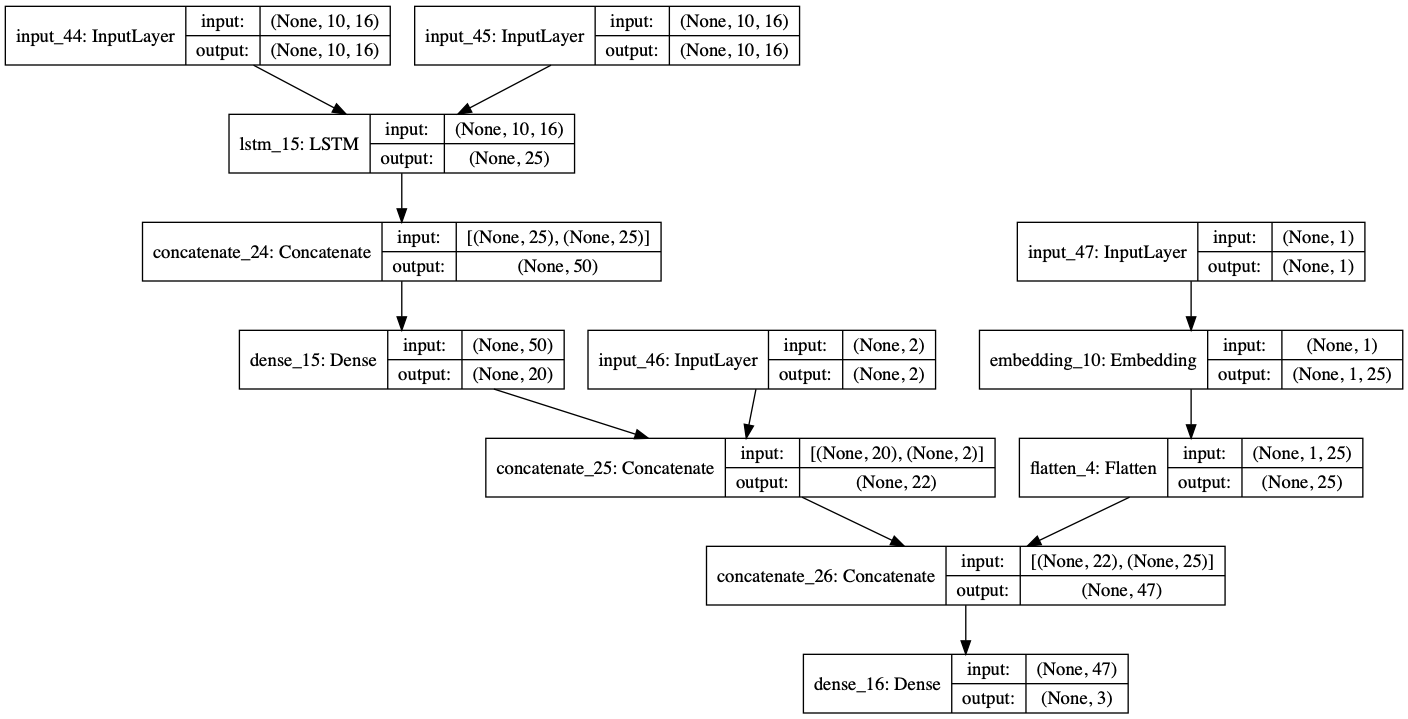

In [289]:
plot_model(model,show_shapes=True)

In [290]:
team_1_history_inputs.shape, team_2_history_inputs.shape

((277375, 10, 16), (277375, 10, 16))

In [291]:
current_match_inputs.shape

(277375, 2)

In [292]:
league_embed_ids.shape

(277375,)

In [293]:
y.shape

(277375,)

In [295]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

In [296]:
history = model.fit([team_1_history_inputs, team_2_history_inputs,current_match_inputs,league_embed_ids],y,batch_size = 128,epochs = 50,validation_split=0.05)

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 263506 samples, validate on 13869 samples
Epoch 1/50
263506/263506 [==============================] - 19s 72us/step - loss: 1.0145 - accuracy: 0.4985 - val_loss: 1.0101 - val_accuracy: 0.5000
Epoch 2/50
263506/263506 [==============================] - 18s 68us/step - loss: 1.0029 - accuracy: 0.5068 - val_loss: 1.0088 - val_accuracy: 0.5005
Epoch 3/50
263506/263506 [==============================] - 18s 68us/step - loss: 1.0004 - accuracy: 0.5078 - val_loss: 1.0100 - val_accuracy: 0.4990
Epoch 4/50
263506/263506 [==============================] - 18s 69us/step - loss: 0.9992 - accuracy: 0.5096 - val_loss: 1.0100 - val_accuracy: 0.5025
Epoch 5/50
263506/263506 [==============================] - 18s 70us/step - loss: 0.9984 - accuracy: 0.5101 - val_loss: 1.0115 - val_accuracy: 0.5022
Epoch 6/50
263506/263506 [==============================] - 18s 69us/step - loss: 0.9976 - accuracy: 0.5105 - val_loss: 1.0104 - val_accuracy: 0.4997
Epoch 7/50
263506/263506 [=======================

In [298]:
preds = np.argmax(model.predict([team_1_history_inputs, team_2_history_inputs,current_match_inputs,league_ids_inputs]),axis = 1)

In [299]:
pd.crosstab(preds,y)

col_0,0,1,2
row_0,,,
0,3778,2845,2750
1,18379,40457,20296
2,45410,42772,100688


In [300]:
probs = model.predict([team_1_history_inputs, team_2_history_inputs,current_match_inputs,league_ids_inputs])

In [311]:
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score

In [307]:
pd.crosstab((probs[:,2] > 0.9).astype(int),(y ==2).astype(int))

col_0,0,1
row_0,,
0,153523,122081
1,118,1653


In [316]:
roc_auc_score((probs[:,1] > 0.9).astype(int),(y ==1).astype(int))

0.8087203248672329

In [314]:
print(classification_report((probs[:,2] > 0.9).astype(int),(y ==2).astype(int)))

              precision    recall  f1-score   support

           0       1.00      0.56      0.72    275604
           1       0.01      0.93      0.03      1771

    accuracy                           0.56    277375
   macro avg       0.51      0.75      0.37    277375
weighted avg       0.99      0.56      0.71    277375



In [309]:
pd.crosstab((probs[:,1] > 0.9).astype(int),(y ==1).astype(int))

col_0,0,1
row_0,,
0,191267,85644
1,34,430


In [315]:
match_stats

,match_stats_id,attacks,dangerous_attacks,first_half_time_goals,first_half_time_goals_against,home_team,match_id,match_result,match_start_time,off_targets,on_targets,red_cards,second_half_time_goals,second_half_time_goals_against,shots,team_id,yellow_cards,home_team_cat,match_result_cat,league_id,women,women_cat,league_name,league_type,team_name,ASIAN,GOALLINE,league_type_cat,match_result_cat_0,match_result_cat_1,match_result_cat_2
0,c232588781b68c0c6be34342c83c3799,73,48,1,0,b'\x01',178317,DRAW,2016-01-02 16:36:00,5,4,0,1,2,9,6470,2,1,0,3,b'\x00',0,澳大利亚A联赛,LEAGUE,墨尔本城,0.00,2.75,2,1,0,0
1,822af0bb67616917bd878e2e65e3bfb1,96,76,0,1,b'\x00',178317,DRAW,2016-01-02 16:36:00,10,8,0,2,1,18,278,1,0,0,3,b'\x00',0,澳大利亚A联赛,LEAGUE,悉尼,0.00,2.75,2,1,0,0
2,af1a11358fc4d786a0e175c18a0f2b0d,92,73,1,1,b'\x01',178372,DRAW,2016-01-03 19:00:00,4,6,0,1,1,10,6685,3,1,0,36,b'\x00',0,西班牙甲级联赛,LEAGUE,巴列卡诺,0.00,2.25,2,1,0,0
3,c56b4bc2b6c7b85db1c709bf701af053,106,75,1,1,b'\x00',178372,DRAW,2016-01-03 19:00:00,6,8,0,1,1,14,6471,3,0,0,36,b'\x00',0,西班牙甲级联赛,LEAGUE,皇家社会,0.00,2.25,2,1,0,0
4,82d65d36698b960236ee5dd68fe438f6,98,80,3,0,b'\x01',182425,WIN,2016-01-21 14:37:00,8,7,0,2,0,15,10205,0,1,2,903,b'\x00',0,新西兰足球锦标赛,LEAGUE,WaiBOP联,-0.25,3.50,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797373,eb083f0d89c7ae16690faf76fb9cd13f,120,43,1,1,b'\x00',674176,DRAW,2019-09-28 21:02:00,3,3,0,0,0,6,13925,2,0,0,1197,b'\x00',0,赞比亚超级联赛,LEAGUE,尼克瓦茲,0.00,2.00,2,1,0,0
797374,dc486f65f9700d2b384cf029e240a69f,181,105,0,1,b'\x01',673203,WIN,2019-09-29 16:01:00,15,8,0,3,0,23,15688,3,1,2,2181,b'\x00',0,罗马尼亚Liga II,LEAGUE,蒂米什瓦拉里彭西亚,-1.50,3.00,2,0,0,1
797375,bd76ccd6ef773dd469a3328b96722f92,109,34,1,0,b'\x00',673203,LOSE,2019-09-29 16:01:00,3,2,1,0,3,5,26927,3,0,1,2181,b'\x00',0,罗马尼亚Liga II,LEAGUE,Sportul斯纳戈夫,-1.50,3.00,2,0,1,0
797378,99612b540ded8f2e1db97d059960a709,117,92,0,0,b'\x01',673086,LOSE,2019-09-26 19:29:00,10,3,0,0,1,13,3610,6,1,1,22,b'\x00',0,土耳其杯,CUP,哈塔斯堡,-2.00,3.75,0,0,1,0
